In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from random import normalvariate
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy import fftpack,signal
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.special import jv
from scipy import interpolate, integrate
from scipy.integrate import complex_ode,simpson
from scipy import special
from arc import *
from scipy.optimize import curve_fit
from sympy.physics.wigner import wigner_3j ,wigner_6j
#from maxwellbloch import mb_solve, field, ob_atom
import matplotlib as mpl
from scipy.integrate import quad

In [7]:
# 在紧束缚模型下构造 ML Wannier 函数
def RM(J1,J2,Delta,k):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    H = (J1+J2*np.cos(k))*sigmax + J2*np.sin(k)*sigmay + Delta*sigmaz
    return H

def Wanniercoeff(J1,J2,Delta,k):
    k1 = np.append(k,np.pi)
    EigenVector = np.zeros((len(k1),2,1),dtype=complex)
    coeff = np.zeros(len(k),dtype=complex)
    for i in np.arange(len(k1)):
        H = RM(J1,J2,Delta,k1[i])
        EigenE,EigenV = np.linalg.eigh(H)
        EigenVector[i] = EigenV[:,0].reshape(2,1)
    for i in np.arange(len(k)):
        coeff[i] = (EigenVector[i+1].T.conjugate()@EigenVector[i])[0][0]
    #coeff[-1] = (EigenVector[0].T.conjugate()@EigenVector[-1])[0][0]
    return coeff, EigenVector
        
def getXmm1(J1,J2,Delta,k,dk,m,m1,N):
    coeff,EigenVector = Wanniercoeff(J1,J2,Delta,k)    
    mm1 = 1/N*np.exp(1j*m*(k+dk)-1j*m1*k)
    Matrix  = np.zeros((2,2),dtype=complex)
    for i in np.arange(len(k)):
        Matrix += coeff[i]*mm1[i]*(EigenVector[i+1]@EigenVector[i].T.conjugate())
    #Matrix += coeff[-1]*mm1[-1]*EigenVector[0]@EigenVector[-1].T.conjugate()
    return Matrix

def getXOperator(J1,J2,Delta,k,dk,N):
    #m = np.arange(N)
    Hx = np.zeros((N*2,N*2),dtype=complex)
    for i in np.arange(N):
        for j in np.arange(N):
            Hx[i*2:(i+1)*2][:,j*2:(j+1)*2] = getXmm1(J1,J2,Delta,k,dk,i,j,N)
    return Hx

def Ramanreal(J1,J2,Delta,N):
    H = np.zeros((N*2,N*2),dtype=complex)
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    gamma1 = Delta*sigmaz  + J1*sigmax
    gamma2 = J2*sigmax/2 + 1j*1/2*J2*sigmay
    gamma21 = J2*sigmax/2 - 1j*1/2*J2*sigmay
    H = np.zeros((N*2,N*2),dtype=complex)
    for i in np.arange(N):
        for j in np.arange(N):
            if i==j:
                H[i*2:(i+1)*2][:,j*2:(j+1)*2] = gamma1
            if i == j-1:
                H[i*2:(i+1)*2][:,j*2:(j+1)*2] = gamma21
            if i == j+1:
                H[i*2:(i+1)*2][:,j*2:(j+1)*2] = gamma2
    H[0:2][:,2*(N-1):2*N] = gamma2
    H[2*(N-1):2*N][:,0:2] = gamma21
    return H


def CurrentOp(J2,N):
    H = np.zeros((N*2,N*2),dtype=complex)
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    
    gamma2 = -1j*1/2*J2*sigmax + 1/2*J2*sigmay
    gamma21 = +1j*1/2*J2*sigmax  + 1/2*J2*sigmay
    H = np.zeros((N*2,N*2),dtype=complex)
    for i in np.arange(N):
        for j in np.arange(N):
            if i == j-1:
                H[i*2:(i+1)*2][:,j*2:(j+1)*2] = gamma21
            if i == j+1:
                H[i*2:(i+1)*2][:,j*2:(j+1)*2] = gamma2
    H[0:2][:,2*(N-1):2*N] = gamma2
    H[2*(N-1):2*N][:,0:2] = gamma21
    return H



def Evlolve(J,delta,Delta,N,phi0,T):
    t = np.linspace(0,T,10000)
    phi = np.zeros((len(t),2*N,1),dtype=complex)
    phi[0] = phi0
    Deltat = Delta*np.cos(2*np.pi*t/T+np.pi/4)
    J1 = J + delta*np.sin(2*np.pi*t/T+np.pi/4)
    J2 = J - delta*np.sin(2*np.pi*t/T+np.pi/4)
    dt = t[1]-t[0]
    for i in np.arange(len(t)-1):
        H = Ramanreal(J1[i],J2[i],Deltat[i],N)
        dU = expm(-1j*H*dt)
        phi[i+1] = dU@phi[i]
    return phi
    
    

In [4]:
N = 100
k = np.arange(-np.pi,np.pi,2*np.pi/N)
dk = k[1]-k[0]
J,delta,Delta = 1,0.5, 1
Deltat = Delta*np.cos(np.pi/4)
J1 = J + delta*np.sin(np.pi/4)
J2 = J - delta*np.sin(np.pi/4)
H = getXOperator(J1,J2,Deltat,k,dk,N)
E,V = np.linalg.eig(H)

d:\anaconda\lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\anaconda\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


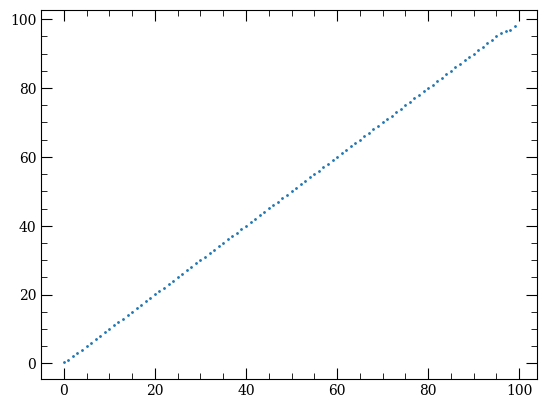

In [5]:
indices = np.where(np.abs(E) > 0.1)[0]
Center = np.zeros(len(indices),dtype=complex)
positon = np.kron(np.diag(np.arange(N)),np.eye(2))
for i in np.arange(len(indices)):
    Center[i] = (((V[:,indices[i]].reshape(len(E),1)).T.conjugate())@positon@V[:,indices[i]].reshape(len(E),1))[0][0]
indexV = np.argsort(Center)
plt.scatter(np.arange(len(Center)),Center[indexV],s=1)


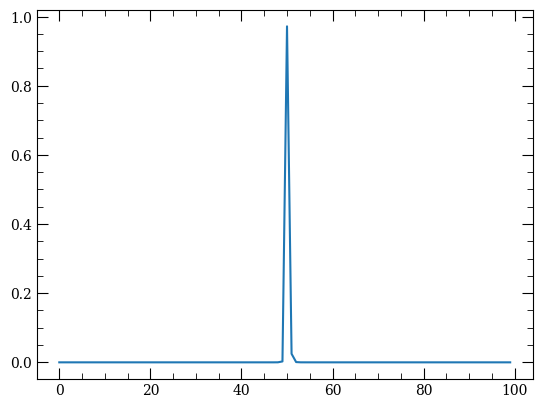

In [6]:
phi0 = (V[:,indices[indexV[50]]]).reshape(2*N,1)
plt.plot(np.arange(N),np.abs(phi0[::2])**2+np.abs(phi0[1::2])**2)

In [8]:
T = 100
rho = Evlolve(J,delta,Delta,N,phi0,T)

In [16]:
t = np.linspace(0,T,10000)
J2 = J - delta*np.sin(2*np.pi*t/T+np.pi/4)
dcom = np.zeros(len(rho),dtype=complex)
for i in np.arange(len(rho)):
    current = CurrentOp(J2[i],N)
    dcom[i] = (rho[i].T.conjugate()@current@rho[i])[0][0]

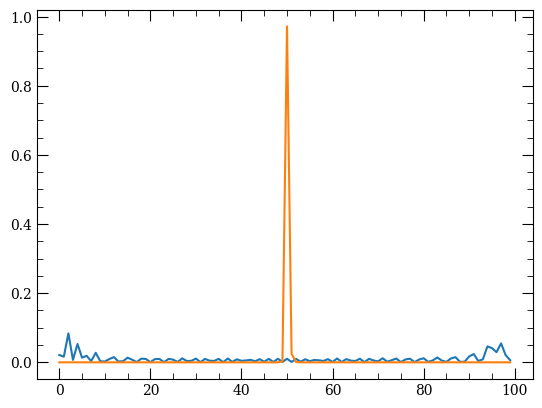

In [10]:
plt.plot(np.arange(N),np.abs(rho[-1,::2])**2+np.abs(rho[-1,1::2])**2)
plt.plot(np.arange(N),np.abs(rho[0,::2])**2+np.abs(rho[0,1::2])**2)

In [11]:
COM = np.zeros(len(rho),dtype=complex)
positon = np.kron(np.diag(np.arange(N)),np.eye(2))
for i in np.arange(len(rho)):
    COM[i] = ((rho[i].T.conjugate())@positon@rho[i])[0][0]
    

(-0.6702576643870515+4.336808689942018e-19j)
(-0.9571892455613678-1.378104564885663e-17j)


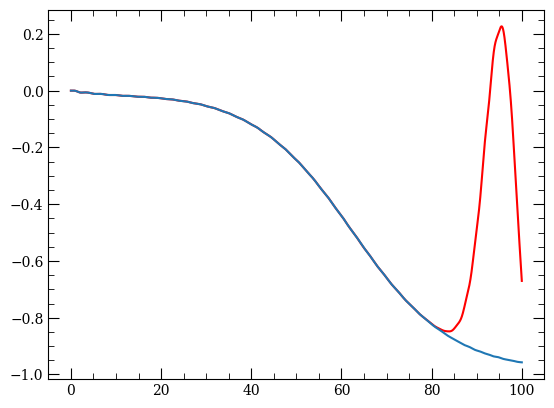

In [18]:
time = np.linspace(0,T,10000)
dt = time[1]-time[0]
plt.plot(np.linspace(0,T,10000),COM-COM[0],c='r')
plt.plot(np.linspace(0,T,10000),np.cumsum(dcom)*dt)
print(COM[-1]-COM[0])
print((np.cumsum(dcom)*dt)[-1])

In [24]:
# 计算 m + coskx + cosky sinkx sinky 的1D 能带和pump 电流
def Ramanreal(m,ky,N):
    H = np.zeros((N*2,N*2),dtype=complex)
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    gamma1 = m*sigmaz  + np.cos(ky)*sigmaz + np.sin(ky)*sigmay
    gamma2 = 1/2*sigmaz + 1j*1/2*sigmax
    gamma21 = 1/2*sigmaz - 1j*1/2*sigmax
    H = np.zeros((N*2,N*2),dtype=complex)
    for i in np.arange(N):
        for j in np.arange(N):
            if i==j:
                H[i*2:(i+1)*2][:,j*2:(j+1)*2] = gamma1
            if i == j-1:
                H[i*2:(i+1)*2][:,j*2:(j+1)*2] = gamma21
            if i == j+1:
                H[i*2:(i+1)*2][:,j*2:(j+1)*2] = gamma2
    return H

def VecOperator(kx):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    H = -np.sin(kx)*sigmaz + np.cos(kx)*sigmax
    return H

def COMqt1(m,omega):
    T = 2*np.pi/omega
    t = np.linspace(0,T,1000)
    dt = t[1]-t[0]
    ky = t*2*np.pi/T
    kx = np.linspace(-np.pi,np.pi,500)
    dkx = kx[1]-kx[0]
    Compositon = np.zeros((len(kx),len(t)),dtype=complex)
    for qi in np.arange(len(kx)):
        veff = VecOperator(kx[qi])
        U = np.eye(2)
        Hin = Ramanq(m,0,kx[qi])
        Ein,Vin = np.linalg.eigh(Hin)
        phi0 = Vin[:,0].reshape(2,1)
        for ti in np.arange(len(t)):
            Hefft = Ramanq( m,ky[ti],kx[qi])
            U = expm(-1j*Hefft*dt)@U
            phit = U@phi0
            Compox = phit.T.conjugate()@veff@phit*dt*dkx
            Compositon[qi][ti] = Compox[0][0]
    return Compositon, kx, ky


def Ramanq(m,ky,kx):
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    H = (m+np.cos(kx)+np.cos(ky))*sigmaz + np.sin(kx)*sigmax + np.sin(ky)*sigmay
    return H

def COMqt(m,omega):
    T = 2*np.pi/omega
    t = np.linspace(0,T,2000)
    dt = t[1]-t[0]
    ky = t*2*np.pi/T
    kx = np.linspace(-np.pi,np.pi,1000)
    dkx = kx[1]-kx[0]
    kx1 = np.append(kx,np.pi+dkx)
    kx2 = np.insert(kx,0,-np.pi-dkx)
    Compositon = np.zeros((len(kx),len(t)),dtype=complex)
    for qi in np.arange(len(kx)):
        U = np.eye(2)
        Hin = Ramanq(m,0,kx[qi])
        Ein,Vin = np.linalg.eigh(Hin)
        phi0 = Vin[:,0].reshape(2,1)
        for ti in np.arange(len(t)):
            Hefft = Ramanq( m,ky[ti],kx[qi])
            Hefft1 = Ramanq( m,ky[ti],kx1[qi+1]) 
            Hefft2 =  Ramanq( m,ky[ti],kx2[qi])
            veff = (Hefft1-Hefft2)/dkx/2 # + Unity@Hefft - Hefft@Unity 
            U = expm(-1j*Hefft*dt)@U
            phit = U@phi0
            Compox = phit.T.conjugate()@veff@phit*dt*dkx
            Compositon[qi][ti] = Compox[0][0]
    return Compositon, kx, ky

In [25]:
m = 1
omega = 0.05
Compositon,kx,ky = COMqt1(m,omega)

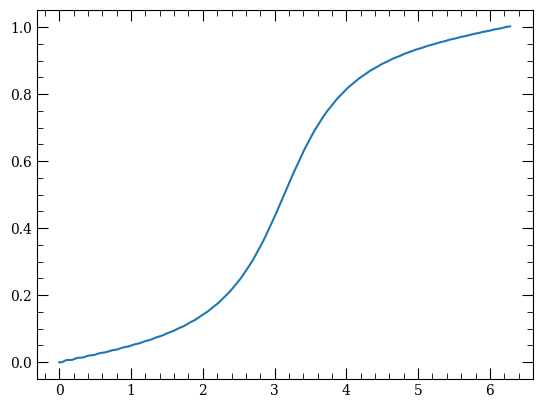

In [27]:

COMT = np.sum(Compositon, axis=0)
plt.plot(ky,np.cumsum(COMT)/2/np.pi)

In [19]:
m = 1
ky = np.linspace(-np.pi,np.pi,100)
N = 50
En = np.zeros((len(ky),N*2),dtype=complex)
for i in np.arange(len(ky)):
    H = Ramanreal(m,ky[i],N)
    En[i] = np.linalg.eigvalsh(H)

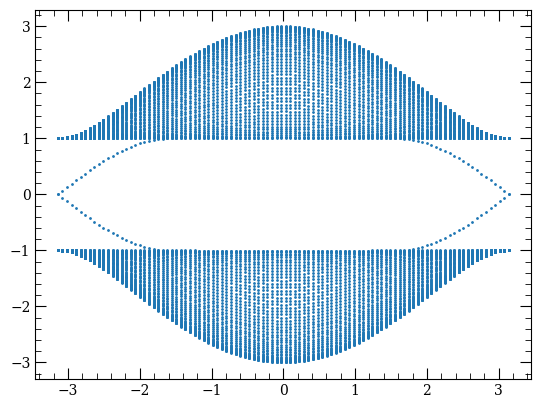

In [20]:
plt.scatter(np.repeat(ky,N*2),En.flatten(),s=1)